In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

## 1 定义导入路径

In [2]:
# 获取当前工作目录
current_dir = Path().absolute()

# 定义导入路径
folder_path = current_dir / "Inputs"

## 2 设定情景参数

In [3]:
# 本次优化问题的距离上限
max_dis = 300

# 抽样次数
num_samples = 100

# 发电技术种类
Gen_type = 'wipp'

# Maximum mix rate of sludge mass in total fuel mass
MixRate = 0.2 # 0.05  0.2

# the ratio of lower bound to Maximum mix rate 
l_ratio = 0.05

# M0.05 l:0.2,0.5,0.8
# M0.2 l:0.05,0.125,0.2

# Growth rate of sludge production
growth_rate = 1 # BAU: 1 #1.0425, 1.1418

## 3 定义导出路径

In [4]:
# 优化结果
folder_GHG = current_dir / f"Outputs/GHG_{Gen_type}_{num_samples}_M{MixRate}_L{l_ratio}_S2_V4"
os.makedirs(folder_GHG, exist_ok=True)

# 优化日志
log_dir = folder_GHG / "logs"
os.makedirs(log_dir, exist_ok=True)

# 模型结构
# junk_dir =  folder_GHG / "junk_file"
# os.makedirs(junk_dir, exist_ok=True)

## 4 数据导入

In [5]:
# WWTP
file_WWTP = os.path.join(folder_path, "WWTP_corrected.xlsx")
df_WWTP = pd.read_excel(file_WWTP)

In [6]:
# WIPP
file_WIPP =  os.path.join(folder_path, "WIPP.xlsx")
df_WIPP = pd.read_excel(file_WIPP)

file_plant_waste =  os.path.join(folder_path, "waste_inceration_plants_2020_operating.xlsx")
df_plant_waste = pd.read_excel(file_plant_waste)

In [7]:
# distance
file_distance_nation_WIPP = os.path.join(folder_path, f"distance_wipp_nation_{max_dis}.csv")
df_distance_nation_wipp = pd.read_csv(file_distance_nation_WIPP)

In [8]:
file_intesity =  os.path.join(folder_path, "province_intensity.xlsx")
df_intesity = pd.read_excel(file_intesity,usecols=['Province','GHG_emis_tCO2eq/kWh'])

# file_NC = os.path.join(folder_path, f"NC_categoried_{num_samples}.xlsx")
# df_nc = pd.read_excel(file_NC)

# Costs for Monte Carlo Simulation
# Net costs
file_NC =  os.path.join(folder_path, f"NC_old_nation_{num_samples}_monthly.csv")
df_nc = pd.read_csv(file_NC)

# NC_cowaste
file_NC_cowaste =  os.path.join(folder_path, f"NC_cowaste_{num_samples}.xlsx")
df_NC_cowaste = pd.read_excel(file_NC_cowaste)

## 5 参数设定

In [9]:
## GHG emission factors (water content: 45%)

GHG_SludgeBurn = 0.0798 # GHG emissions of sludge burning on average (tCO2eq/t)

GHG_SludgeLandApp = (0.1065+0.3184)/2 # GHG emissions of sludge treatment by land application (tCO2eq/t)
GHG_SludgeBuild = -0.1701 # GHG emissions of sludge treatment by building material utilization (tCO2eq/t)
GHG_SludgeInci = -0.3132 # GHG emissions of sludge incineration with energy recovery (tCO2eq/t)
GHG_SludgeLandfill = 0.8672 # GHG emissions of sludge treatment by sanitary landfill (tCO2eq/t)
GHG_SludgeOther = 0.0891 # GHG emissions of sludge treatment by other applications (tCO2eq/t)

GHG_CoalBurn = 1.99 # GHG emissions of coal burning on average (tCO2eq/t)
GHG_CoalMini = 0.18 # GHG emission factor of coal mining and processing (tCO2eq/t)

GHG_SludgeTrans = 0.123/1000 # GHG emission factor of sludge transport (tCO2eq/km)

GHG_Elec_province = dict(zip(df_intesity['Province'], df_intesity['GHG_emis_tCO2eq/kWh']))
# GHG emission factor of grid electricity (tCO2eq/kWh)

In [10]:
# 生活垃圾焚烧发电厂所在省份度电碳排放量 GHG_Elec_waste[k] 

region_k = df_plant_waste['Pro_en']
GHG_Elec_waste = dict()
for k in range(len(region_k)):
    GHG_Elec_waste[k] = GHG_Elec_province[region_k[k]]

In [11]:
## 各月WWTP污泥提供量 SludgeSupply[i,m] 
## 各月厂污泥处置综合排放系数 SludgeTreatmentfactor[i,m]

month_WWTP = df_WWTP['Statistical month']
supply = df_WWTP['含水率45%时的总污泥处理量（吨/月）']
landapp = df_WWTP['含水率45%时的土地利用量（吨）']
building = df_WWTP['含水率45%时的建材利用量（吨）']
incineration = df_WWTP['含水率45%时的焚烧利用量（吨）']
landfill = df_WWTP['含水率45%时的卫生填埋量（吨）']
other = df_WWTP['含水率45%时的其他处置量（吨）']
item = df_WWTP['Plantcode']

SludgeSupply = dict() 
SludgeTreatmentfactor = dict() 
wwtp_counter = 0

for k in range(len(month_WWTP)):
    m = int(month_WWTP[k])-202000-1
    SludgeSupply[wwtp_counter, m] = round(supply[k]*growth_rate/1000,2)
    
    if supply[k] == 0:
        SludgeTreatmentfactor[wwtp_counter, m] = round(0,2)
    else: SludgeTreatmentfactor[wwtp_counter, m] = round((landapp[k]*GHG_SludgeLandApp+building[k]*GHG_SludgeBuild+
                                                                 incineration[k]*GHG_SludgeInci+landfill[k]*GHG_SludgeLandfill+
                                                                 other[k]*GHG_SludgeOther)/supply[k],2)
     
    if m == 11:
        wwtp_counter = wwtp_counter + 1

In [12]:
# 各WWTP污泥处置成本 NC_old[i,num,m]
NC_old = dict()
for k in range(len(df_nc['value'])):
    num_counter = df_nc['num'][k]
    i = df_nc['FID'][k]
    m = df_nc['m'][k]
    value = df_nc['value'][k]
    
    NC_old[num_counter,i,m] = value

# month_WWTP = df_WWTP['Statistical month']
# supply = df_WWTP['含水率45%时的总污泥处理量（吨/月）']
# landapp = df_WWTP['含水率45%时的土地利用量（吨）']
# building = df_WWTP['含水率45%时的建材利用量（吨）']
# incineration = df_WWTP['含水率45%时的焚烧利用量（吨）']
# landfill = df_WWTP['含水率45%时的卫生填埋量（吨）']
# other = df_WWTP['含水率45%时的其他处置量（吨）']
# item = df_WWTP['项目编号']

# NC_landappli = df_nc['NC_landappli']
# NC_building = df_nc['NC_building']
# NC_inci = df_nc['NC_inci']
# NC_landfill = df_nc['NC_landfill']
# NC_other = df_nc['NC_other']

# NC_monthly = dict()
# NC_old = dict()
# index_counter = { num: 0 for num in range(num_samples)}



# for num in range(num_samples):
#     for k in range(len(month_WWTP)):
#         m = int(month_WWTP[k])-202000-1
        
#         wwtp_counter = index_counter[num]
    
#         if (wwtp_counter,num) not in NC_old:
#             NC_old[wwtp_counter,num] = 0
    
#         if supply[k] == 0:
#             NC_monthly[wwtp_counter, m] = 0
#         else: NC_monthly[wwtp_counter, m] = (landapp[k]*NC_landappli[num]+
#                                              building[k]*NC_building[num]+
#                                              incineration[k]*NC_inci[num]+
#                                              landfill[k]*NC_landfill[num]+
#                                              other[k]*NC_other[num])/supply[k]
#         NC_old[wwtp_counter,num] += NC_monthly[wwtp_counter, m]
    
#         if m == 11:
#             NC_old[wwtp_counter,num] = round(NC_old[wwtp_counter,num]/12,4)
#             index_counter[num] = index_counter[num] + 1
            
# data = [(key[0], key[1], value) for key, value in NC_old.items()]
# df = pd.DataFrame(data, columns=['FID', 'num', 'value'])

# csv_path = fr'E:/Test/Inputs/costs/NC_old_nation_{num_samples}.csv'
# df.to_csv(csv_path, index=False)

In [13]:
NC_cowaste = dict()

for num in range(num_samples):
    NC_cowaste[num] = df_NC_cowaste['NC_cowaste'][num]

In [14]:
## 各月WIPP污泥需求量上限 SludgeDemand_WIPP[k,m]

month_WIPP = df_WIPP['Statistical month']
# demand_WIPP = df_WIPP['Monthly_Waste_Ele_t'] * MixRate
demand_WIPP_1 = df_WIPP['Monthly_Waste_Ele_t'] * MixRate
demand_WIPP_2 = df_WIPP['Monthly_Waste_Heat_t'] * MixRate
demand_WIPP = demand_WIPP_1 + demand_WIPP_2

SludgeDemand_WIPP = dict() 
wipp_counter = 0

for o in range(len(month_WIPP)):
    m_w = int(month_WIPP[o])-202000-1
    SludgeDemand_WIPP[wipp_counter, m_w] = demand_WIPP[o]/1000
    
    if m_w == 11:
        wipp_counter = wipp_counter + 1

In [15]:
## WWTPs到WIPPs的距离 Distance_WIPP[i,k] km
## 加入时间维度，WWTPs到CFPPs的距离 annual_Distance_WIPP[i,k,m] km

distance_wipp = df_distance_nation_wipp['distance']
WWTP = df_distance_nation_wipp['INPUT_FID']
WIPP = df_distance_nation_wipp['NEAR_FID']

Distance_WIPP = dict()
annual_Distance_WIPP = dict()

for q in range(len(distance_wipp)):
    wwtp = int(WWTP[q])
    wipp = int(WIPP[q])
    Distance_WIPP[wwtp, wipp] = round(distance_wipp[q],2)
    
    for m in range(12):
        annual_Distance_WIPP[wwtp,wipp,m] = round(distance_wipp[q],2) 

In [16]:
## 经济距离约束下，可能与ith WWTP协同的垃圾焚烧电厂：WWTP_wipp_possiblelinkage[i]
## 经济距离约束下，可能协同的污水厂名单：wwtp_wipp_list = []

WWTP_wipp_possiblelinkage = dict()
wwtp_wipp_list = []

for key in Distance_WIPP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_wipp_possiblelinkage:
        WWTP_wipp_possiblelinkage[first_digit] = []  
        
    WWTP_wipp_possiblelinkage[first_digit].append(key)   
    
    if first_digit not in wwtp_wipp_list:
        wwtp_wipp_list.append(first_digit) 

In [17]:
## 加入时间维度，经济距离约束下，可能与ith WWTP协同的垃圾焚烧电厂：annual_WWTP_wipp_pl[i,m]

annual_WWTP_wipp_pl = dict()


for wwtp in wwtp_wipp_list:
    for m in range(12):
        annual_WWTP_wipp_pl[wwtp, m] = []

for key in annual_Distance_WIPP.keys():
    digit_1 = key[0]
    digit_3 = key[2]
    annual_WWTP_wipp_pl[digit_1,digit_3].append(key)

In [18]:
## 经济距离约束下，可能与kth WIPP配对的污水厂：WIPP_possiblelinkage[k]:[(i,k)]
## 经济距离约束下，可能协同的电厂名单：wipp_list = []

WIPP_possiblelinkage = dict()
wipp_list = []

for key in sorted(Distance_WIPP.keys(), key=lambda x: x[1]): 
    second_digit = key[1]
    
    if second_digit not in WIPP_possiblelinkage:
        WIPP_possiblelinkage[second_digit] = [] 
        
    WIPP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in wipp_list:
        wipp_list.append(second_digit)    

In [19]:
## 加入时间维度，经济距离约束下，可能与kth WIPP配对的污水厂：annual_WIPP_possiblelinkage[k,m]

annual_WIPP_possiblelinkage = dict()


for wipp in wipp_list:
    for m in range(12):
        annual_WIPP_possiblelinkage[wipp, m] = []

for key in annual_Distance_WIPP.keys():
    digit_2 = key[1]
    digit_3 = key[2]
    annual_WIPP_possiblelinkage[digit_2,digit_3].append(key)

## 6 模型构建与求解

In [20]:
# 封装函数
# 单位：ktCO2eq, thousand CNY

def Optimize_GHG_01_Nation(M,num,log_filepath):

    # Create a new model
    model = gp.Model(f"GHG_wipp_{num}")
    
    # Define the folder path of log file
    model.setParam("LogFile", log_filepath)
    
    # Create variables
    weight_wipp = model.addVars(annual_Distance_WIPP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_wipp')
    z_wipp = model.addVars(wipp_list,vtype=GRB.BINARY, name='z_wipp')

    # Define the component of objective
    # onsite fuel combustion - waste
    obj1 = gp.quicksum(weight_wipp[wipp_index]*GHG_SludgeBurn 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge treatment - waste
    obj2 = gp.quicksum(-weight_wipp[wipp_index]*SludgeTreatmentfactor[wipp_index[0],wipp_index[2]] 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge dehydration - waste
    obj3 = gp.quicksum(weight_wipp[wipp_index]*28*GHG_Elec_waste[wipp_index[1]] 
                       for wipp_index in annual_Distance_WIPP.keys())

    # sludge transport - waste
    obj4 = gp.quicksum(weight_wipp[wipp_index]*GHG_SludgeTrans*annual_Distance_WIPP[wipp_index] 
                       for wipp_index in annual_Distance_WIPP.keys())


    # Set objective
    model.setObjective(obj1+obj2+obj3+obj4,GRB.MINIMIZE)


    # Add constraints
    # Supply limit
    model.addConstrs(gp.quicksum(weight_wipp[wwtp_link] for wwtp_link in annual_WWTP_wipp_pl[i,m]) <= SludgeSupply[i,m] 
                     for i in wwtp_wipp_list for m in range(M))

    # Maximum Demand 
    model.addConstrs(gp.quicksum(weight_wipp[wipp_link] for wipp_link in annual_WIPP_possiblelinkage[k,m]) <= SludgeDemand_WIPP[k,m]*z_wipp[k]
                     for k in wipp_list for m in range(M))
    
    # Minimum Demand
    model.addConstrs(gp.quicksum(weight_wipp[wipp_link] for wipp_link in annual_WIPP_possiblelinkage[k,m]) >= l_ratio*SludgeDemand_WIPP[k,m]*z_wipp[k]
                     for k in wipp_list for m in range(M))
    
    # Economic Constraint : 经济约束（按厂年经济成本添加）
    model.addConstrs( 
        gp.quicksum(weight_wipp[wipp_link]* (Distance_WIPP[wipp_link[0],k]*0.65-NC_old[num,wipp_link[0],m]+NC_cowaste[num])
                                for m in range(M) 
                                for wipp_link in annual_WIPP_possiblelinkage[k,m]) <= 0 
                     for k in wipp_list
                    )

    # 设置 MIPGap 参数，设定为 0.01（1%）
    model.setParam('MIPGap', 0.005)
    
    # Optimize model
    model.optimize()
    
    # 获取目标函数值
    obj_expr = model.getObjective()
    obj_value = obj_expr.getValue()
    
    # 获取各部分目标函数值
    obj1_val = obj1.getValue()
    obj2_val = obj2.getValue()
    obj3_val = obj3.getValue()
    obj4_val = obj4.getValue()
    
    return model,weight_wipp,z_wipp,obj_value,obj1_val,obj2_val,obj3_val,obj4_val
    

In [21]:
# 函数调用并储存结果

unit_obj = []

for num in range(num_samples):
    
    # Model Parameters
    M = 12

    log_filename = f"GHG_wipp_{num}.log"
    log_filepath = os.path.join(log_dir, log_filename)    
    

    model,weight_wipp,z_wipp,obj_value,obj1_val,obj2_val,obj3_val,obj4_val = Optimize_GHG_01_Nation(M,num,log_filepath)
         
        
    # 获取决策变量优化结果
    opt_weight = model.getAttr("X",weight_wipp)
    linkage = {key: value for key, value in opt_weight.items() if value > 0.0001}

    weight = []
    for key,value in linkage.items():
        i = key[0]
        k = key[1]
        m = key[2]
        weight.append([i, k, m, value]) 

    df_weight = pd.DataFrame(weight, columns=['I', 'K', 'M', 'opt_weight_wipp'])
    w_wipp = df_weight['opt_weight_wipp'].sum()
    
    excel_filename = os.path.join(folder_GHG, f"wipp_{num}.csv")
    df_weight.to_csv(excel_filename, index=False)
    
    opt_z_wipp = model.getAttr("X",z_wipp)
    z_wipp_val = {key: value for key, value in opt_z_wipp.items()}
    df_m_wipp = pd.DataFrame(list(z_wipp_val.items()), columns=['K', 'z_wipp'])
    df_m_wipp.to_csv(os.path.join(folder_GHG, f"z_wipp_{num}.csv"), index=False)
    
    n_wipp = df_m_wipp['z_wipp'].sum()
    
    unit_obj.append({
        'num':num,
        'obj_value':obj_value,
        'obj1': obj1_val,
        'obj2': obj2_val,
        'obj3': obj3_val,
        'obj4': obj4_val,
        'opt_weight_wipp':w_wipp,
        'n_wipp': n_wipp
        }) 
    
df_unit_obj = pd.DataFrame(unit_obj)

file_result = os.path.join(folder_GHG, f"result_01_{max_dis}.csv")
df_unit_obj.to_csv(file_result,index=False)

Set parameter LicenseID to value 2516810
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_0.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x8f8bd207
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [9e-04, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 14784 rows and 330915 columns (presolve time = 5s)...
Presolve removed 15109 rows and 339016 columns (presolve time = 10s)...
Presolve remov


Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.36s

Barrier statistics:
 AA' NZ     : 4.691e+06
 Factor NZ  : 3.511e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.390e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.12170213e+06 -3.88822680e+06  2.05e+06 4.18e-01  5.92e+02    24s
   1  -4.62953067e+06 -3.62639449e+06  1.15e+06 3.07e-01  3.41e+02    25s
   2  -9.11300116e+05 -3.25500280e+06  2.22e+05 5.68e-02  6.79e+01    26s

Barrier performed 2 iterations in 26.20 seconds (36.15 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.08s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   53366   -2.0686000e+03   0.000000e+00   0.000000e+00     26s

Root relaxation: objective -2.068600e+03, 53366 iterations, 11.99 seconds (1

Presolve removed 15276 rows and 347997 columns
Presolve time: 12.98s
Presolved: 59233 rows, 1500388 columns, 6010459 nonzeros
Found heuristic solution: objective -6.3421997
Variable types: 1499830 continuous, 558 integer (558 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 5.30s

Barrier statistics:
 AA' NZ     : 4.667e+06
 Factor NZ  : 3.455e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.072e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.32292037e+05 -4.52036133e+06  9.46e+05 4.50e-01  4.04e+02    24s
   1  -5.76274168e+05 -4.06390620e+06  5.79e+05 2.72e-01  2.52e+02    25s
   2  -7.15269522e+04 -3.46951135e+06  7.01e+04 5.89e-02  3.18e+01    26s
   3  -3.48759611e+04 -2.25110135e+06  3.52e+04 9.11e-03  1.57e+01    27s
   4  -8.61175722e+03 

H    0     0                    -1697.772081 -1726.0570  1.67%     -   28s
H    0     0                    -1700.552134 -1726.0570  1.50%     -   28s
     0     0 -1726.0570    0   59 -1700.5521 -1726.0570  1.50%     -   29s
     0     0 -1726.0570    0   59 -1700.5521 -1726.0570  1.50%     -   29s
     0     0 -1724.2757    0   23 -1700.5521 -1724.2757  1.40%     -   31s
H    0     0                    -1713.885382 -1724.2747  0.61%     -   32s
H    0     0                    -1717.554411 -1724.2747  0.39%     -   32s

Cutting planes:
  Implied bound: 2619
  MIR: 98
  Flow cover: 151
  RLT: 378
  Relax-and-lift: 41
  BQP: 19

Cleanup yields a better solution

Explored 1 nodes (46971 simplex iterations) in 32.71 seconds (45.12 work units)
Thread count was 16 (of 16 available processors)

Solution count 9: -1718.51 -1717.55 -1713.89 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -1.718510193448e+03, best bound -1.724274661977e+03, gap 0.3354%
Set parameter LogFile to 

H    0     0                    -1270.301194 -1275.1505  0.38%     -   43s

Explored 1 nodes (71563 simplex iterations) in 43.34 seconds (51.02 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: -1270.3 -1158.13 -645.211 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -1.270301194288e+03, best bound -1.275150487209e+03, gap 0.3817%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_10.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0xfc1f2849
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics

Thread count was 16 (of 16 available processors)

Solution count 5: -2062.6 -1917.39 -785.361 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.062601644004e+03, best bound -2.065239909169e+03, gap 0.1279%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_13.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x71fc4ec5
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic so


Root relaxation: objective -2.460213e+03, 50366 iterations, 12.74 seconds (13.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2460.2134    0  149  -46.20115 -2460.2134  5225%     -   31s
H    0     0                    -2216.081583 -2460.2134  11.0%     -   32s
H    0     0                    -2455.758943 -2460.2134  0.18%     -   34s

Explored 1 nodes (50752 simplex iterations) in 34.22 seconds (45.63 work units)
Thread count was 16 (of 16 available processors)

Solution count 4: -2455.76 -2216.08 -46.2012 0 

Optimal solution found (tolerance 5.00e-03)
Best objective -2.455758943496e+03, best bound -2.460213446238e+03, gap 0.1814%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_17.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU mo

Presolve time: 3.05s
Found heuristic solution: objective -82.5220388
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 1.15s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 8.189e+05
 Factor NZ  : 4.987e+06 (roughly 150 MB of memory)
 Factor Ops : 4.611e+09 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.98620770e+06 -4.71053876e+05  5.74e+04 5.51e-01  8.91e+01     9s
   1  -1.20921640e+06 -4.56596590e+05  3.48e+04 9.03e-01  5.33e+01    10s
   2  -5.52389453e+05 -4.40830141e+05  1.58e+04 3.98e-01  2.53e+01    10s
   3  -1.02803932e+05 -3.67913216e+05  2.91e+03 1.20e-02  5.07e+00    10s
   4  -5.98874508e+04 -2.33158523e+05  1.69e+03 1.90e-04  2.74e+00    10s
   5  -2.79971614e+04 -1.60394811e+05  7.79e+02 2.49e-14  1.29e+00    10s
   6  -1.49859531e+04

Presolve time: 13.89s
Presolved: 58993 rows, 1506357 columns, 6033867 nonzeros
Found heuristic solution: objective -0.5395548
Variable types: 1505801 continuous, 556 integer (556 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.25s

Barrier statistics:
 AA' NZ     : 4.684e+06
 Factor NZ  : 3.453e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.069e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.01717144e+07 -2.94893927e+06  1.62e+06 4.79e-01  4.99e+02    25s
   1   4.05616415e+07 -2.82915186e+06  7.28e+05 3.66e-01  2.28e+02    26s
   2   1.61080907e+07 -2.63366614e+06  2.87e+05 1.61e-01  9.33e+01    26s
   3   2.58909384e+06 -2.00217717e+06  4.43e+04 3.04e-03  1.56e+01    27s
   4   1.01674456e+06 -1.47182140e+06  1.7


Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.16s

Barrier statistics:
 AA' NZ     : 4.693e+06
 Factor NZ  : 3.436e+07 (roughly 1.0 GB of memory)
 Factor Ops : 8.999e+10 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.02865410e+05 -4.20644202e+06  1.13e+06 4.88e-01  5.43e+02    24s
   1   5.54523774e+04 -3.92469459e+06  7.45e+05 2.39e-01  3.65e+02    24s
   2   9.61781228e+03 -3.50800009e+06  1.04e+05 3.46e-02  5.22e+01    25s
   3   5.45682949e+03 -2.39856556e+06  4.46e+04 1.72e-03  2.24e+01    26s
   4   3.91767675e+03 -2.11931972e+06  2.14e+04 9.69e-04  1.10e+01    27s
   5   2.72704053e+03 -1.74318689e+06  5.04e+03 8.71e-04  2.98e+00    28s
   6   2.24933204e+03 -1.29636013e+06  2.09e+03 1.32e-04  1.38e+00    29s

Barrier performed 6 iterations in 29.13 seconds (40.23 work units)
Barrier solve interrupted - model solved by an

Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 15042 rows and 405277 columns (presolve time = 5s)...
Presolve removed 17190 rows and 573772 columns (presolve time = 10s)...
Presolve removed 17396 rows and 574569 columns
Presolve time: 14.64s
Presolved: 57113 rows, 1273816 columns, 5096503 nonzeros
Found heuristic solution: objective -48.7120966
Variable types: 1273285 continuous, 531 integer (531 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 4.56s

Barrier performed 0 iterations in 22.82 seconds (36.22 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.06s

Solved with dual simplex

Root simplex log.

Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [2e-03, 3e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 29103 rows and 700873 columns (presolve time = 5s)...
Presolve removed 30186 rows and 733288 columns (presolve time = 10s)...
Presolve removed 30610 rows and 734107 columns
Presolve time: 13.65s
Presolved: 43899 rows, 1114278 columns, 4457392 nonzeros
Variable types: 1113872 continuous, 406 integer (394 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 1.94s

Barrier performed 0 iterations in 18.96 seconds (29.64 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.11s

Solved with primal simplex

Root simplex log...

Iteration    Objective       Primal Inf.  

     0     0 -2173.8765    0   72 -2161.7810 -2173.8765  0.56%     -   31s
H    0     0                    -2167.710643 -2173.8653  0.28%     -   34s

Cutting planes:
  Implied bound: 1971
  MIR: 41
  Flow cover: 145
  RLT: 292
  Relax-and-lift: 22
  BQP: 2

Explored 1 nodes (42991 simplex iterations) in 34.58 seconds (48.06 work units)
Thread count was 16 (of 16 available processors)

Solution count 6: -2167.71 -2161.78 -1977.31 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.167710642841e+03, best bound -2.173865313421e+03, gap 0.2839%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_34.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005



Found heuristic solution: objective -34.9981561
Variable types: 1499540 continuous, 558 integer (558 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.26s

Barrier statistics:
 AA' NZ     : 4.664e+06
 Factor NZ  : 3.391e+07 (roughly 900 MB of memory)
 Factor Ops : 8.503e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.78747637e+07 -4.55373710e+06  1.75e+06 8.84e-01  8.68e+02    26s
   1  -1.84592517e+07 -4.16047381e+06  8.61e+05 3.41e-01  4.35e+02    26s
   2  -8.42149609e+06 -3.74277845e+06  3.90e+05 8.13e-02  2.01e+02    27s
   3  -1.34862908e+06 -3.02725437e+06  6.21e+04 9.95e-14  3.30e+01    28s
   4  -4.41305948e+05 -2.34933337e+06  2.05e+04 1.07e-13  1.12e+01    29s

Barrier performed 4 iterations in 28.64 secon


Explored 1 nodes (58863 simplex iterations) in 33.18 seconds (41.39 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: -1747.71 -1613.54 -757.02 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -1.747712702312e+03, best bound -1.753961263921e+03, gap 0.3575%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_39.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x81abf24d
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [1e-03, 3e+03]
  Objective range  [9e-06, 8e-01]
  Bou


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x4d149cdf
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [5e-04, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 14297 rows and 341900 columns (presolve time = 5s)...
Presolve removed 15510 rows and 355369 columns (presolve time = 10s)...
Presolve removed 15726 rows and 356202 columns (presolve time = 15s)...
Presolve removed 15726 rows and 356202 columns
Presolve time: 15.49s
Presolved: 58783 rows, 1492183 columns, 5974560 nonzeros
Found heuristic solution: objective -52.0073130
Variable types: 1491630 co

H    0     0                    -1801.279117 -1971.9682  9.48%     -   28s
     0     0 -1963.3519    0   62 -1801.2791 -1963.3519  9.00%     -   36s
H    0     0                    -1933.566531 -1963.3471  1.54%     -   38s
H    0     0                    -1953.530509 -1963.3471  0.50%     -   40s
     0     0 -1963.3424    0   61 -1953.5305 -1963.3424  0.50%     -   41s
     0     0 -1963.3423    0   61 -1953.5305 -1963.3423  0.50%     -   41s
     0     0          -    0      -1953.5305 -1963.2886  0.50%     -   44s

Cutting planes:
  Implied bound: 2395
  MIR: 147
  Flow cover: 202
  RLT: 322
  Relax-and-lift: 20
  BQP: 2

Explored 1 nodes (40413 simplex iterations) in 44.76 seconds (55.37 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: -1953.53 -1933.57 -1801.28 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -1.953530508511e+03, best bound -1.963288558404e+03, gap 0.4995%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_10

H    0     0                    -2487.107858 -2490.9663  0.16%     -   37s

Explored 1 nodes (61510 simplex iterations) in 37.45 seconds (49.06 work units)
Thread count was 16 (of 16 available processors)

Solution count 6: -2487.11 -2263.32 -1887.69 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.487107857938e+03, best bound -2.490966346086e+03, gap 0.1551%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_48.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0xb44b2e24
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistic

H    0     0                    -2499.738352 -2504.0912  0.17%     -   37s

Explored 1 nodes (64461 simplex iterations) in 38.07 seconds (45.48 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: -2499.74 -2319.97 -1930.26 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.499738352484e+03, best bound -2.504091206001e+03, gap 0.1741%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_51.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x3f67b2d2
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistic

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 4.89s

Barrier statistics:
 AA' NZ     : 3.680e+06
 Factor NZ  : 2.690e+07 (roughly 700 MB of memory)
 Factor Ops : 6.181e+10 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 23.64 seconds (34.19 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.07s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   45286   -2.2980671e+03   0.000000e+00   0.000000e+00     24s

Root relaxation: objective -2.298067e+03, 45286 iterations, 8.33 seconds (8.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2298.0671    0  136  -46.22844 -2298.0671  4871%     -   26s
H    0     0           

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x9b6e36c8
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 14757 rows and 330766 columns (presolve time = 5s)...
Presolve removed 15177 rows and 343268 columns (presolve time = 10s)...
Presolve removed 15202 rows and 343327 columns
Presolve time: 13.29s
Presolved: 59307 rows, 1505058 columns, 6028973 nonzeros
Found heuristic solution: objective -8.9391091
Variable types: 1504500 continuous, 558 integer (558 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapse


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2273.9237    0  140  -37.27069 -2273.9237  6001%     -   25s
H    0     0                    -1661.884562 -2273.9237  36.8%     -   25s
H    0     0                    -2087.702996 -2273.9237  8.92%     -   25s
     0     0 -2271.5220    0   64 -2087.7030 -2271.5220  8.80%     -   33s
H    0     0                    -2245.032983 -2271.5145  1.18%     -   34s
H    0     0                    -2270.629508 -2271.5145  0.04%     -   35s

Cutting planes:
  Implied bound: 2204
  MIR: 54
  Flow cover: 127
  RLT: 305
  Relax-and-lift: 26
  BQP: 7

Explored 1 nodes (37117 simplex iterations) in 35.93 seconds (49.16 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: -2270.63 -2270.63 -2245.03 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.270629508455e+03, best bound -2.271514465490e

Presolve removed 14899 rows and 337610 columns
Presolve time: 14.21s
Presolved: 59610 rows, 1510775 columns, 6050303 nonzeros
Found heuristic solution: objective -44.7509364
Variable types: 1510218 continuous, 557 integer (557 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.55s

Barrier statistics:
 AA' NZ     : 4.696e+06
 Factor NZ  : 3.564e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.517e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.52939603e+08 -5.94845515e+06  7.82e+05 8.49e-01  8.21e+02    26s
   1  -7.38063585e+07 -5.36606229e+06  3.76e+05 3.72e-01  4.02e+02    27s
   2  -2.54248342e+07 -4.72511568e+06  1.29e+05 1.11e-01  1.41e+02    28s
   3  -4.83356372e+06 -3.42092587e+06  2.44e+04 2.12e-03  2.77e+01  

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.53184110e+08 -9.26242335e+06  8.84e+05 1.20e+00  1.17e+03    28s
   1  -7.88920272e+07 -8.54668574e+06  4.50e+05 5.33e-01  6.09e+02    29s
   2  -3.44581903e+07 -7.85300218e+06  1.96e+05 1.49e-01  2.72e+02    29s
   3  -6.54523128e+06 -6.65786373e+06  3.71e+04 4.26e-13  5.29e+01    30s
   4  -2.56171806e+06 -4.36731072e+06  1.46e+04 5.97e-13  2.10e+01    31s

Barrier performed 4 iterations in 31.43 seconds (40.75 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.47s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   54100   -2.4569022e+03   0.000000e+00   0.000000e+00     32s

Root relaxation: objective -2.456902e+03, 54100 iterations, 14.75 seconds (13.75 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

Presolve removed 14670 rows and 330448 columns (presolve time = 5s)...
Presolve removed 15062 rows and 341890 columns (presolve time = 10s)...
Presolve removed 15173 rows and 342249 columns
Presolve time: 14.27s
Presolved: 59336 rows, 1506136 columns, 6032164 nonzeros
Found heuristic solution: objective -35.5059752
Variable types: 1505579 continuous, 557 integer (557 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.46s

Barrier statistics:
 AA' NZ     : 4.681e+06
 Factor NZ  : 3.540e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.621e+10 (roughly 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.70453387e+07 -7.55668410e+06  1.50e+06 7.33e-01  9.53e+02    26s
   1  -2.82832576e+07 -6.81553373e+06  7.34e+05 4.24e-01  4.74e+02    27s

 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.08712966e+08 -5.33458014e+06  1.45e+06 7.77e-01  7.71e+02    26s
   1  -5.79868433e+07 -4.85126477e+06  7.67e+05 3.82e-01  4.15e+02    26s
   2  -2.83151310e+07 -4.27093979e+06  3.71e+05 1.26e-01  2.04e+02    27s

Barrier performed 2 iterations in 27.59 seconds (38.18 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.09s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   53300   -2.4348379e+03   0.000000e+00   0.000000e+00     28s

Root relaxation: objective -2.434838e+03, 53300 iterations, 12.80 seconds (12.62 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2434.8379    0  148  -39.38060 -2434.837

Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x2c009fc8
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [4e-04, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 15468 rows and 334635 columns (presolve time = 5s)...
Presolve removed 15973 rows and 347659 columns (presolve time = 10s)...
Presolve removed 16111 rows and 348072 columns
Presolve time: 14.78s
Presolved: 58398 rows, 1500313 columns, 6007696 nonzeros
Found heuristic solution: ob


Barrier performed 2 iterations in 27.00 seconds (37.99 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.11s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   63785   -2.4932030e+03   0.000000e+00   0.000000e+00     28s

Root relaxation: objective -2.493203e+03, 63785 iterations, 12.10 seconds (12.82 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2493.2030    0  140  -46.38677 -2493.2030  5275%     -   30s
H    0     0                    -2262.751174 -2493.2030  10.2%     -   30s
H    0     0                    -2488.999873 -2493.2030  0.17%     -   32s

Explored 1 nodes (64212 simplex iterations) in 33.10 seconds (43.20 work units)
Thread count was 16 (of 16 available processors)

Solution count 4: -2489 -2262.75 -46.3868 0 

Optimal solution 

Found heuristic solution: objective 0.0000000
Presolve removed 74509 rows and 1848385 columns
Presolve time: 1.10s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.53 seconds (1.76 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 5.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_81.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0xc9a3055a
Variable types: 1847820 continuous, 565 in

Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [6e-03, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 14714 rows and 330550 columns (presolve time = 5s)...
Presolve removed 15061 rows and 340910 columns (presolve time = 10s)...
Presolve removed 15146 rows and 341157 columns
Presolve time: 13.90s
Presolved: 59363 rows, 1507228 columns, 6036631 nonzeros
Found heuristic solution: objective -21.9846602
Variable types: 1506670 continuous, 558 integer (558 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.44s

Barrier statistics:
 AA' NZ     : 4.685e+06
 Factor NZ  : 3.507e+07 (roughly 1.0 GB of memory)
 Factor Ops : 9.164e+10 (roughly 1 second per iteration)
 Threads    : 6

      

H    0     0                    -1498.992885 -2321.4081  54.9%     -   33s
H    0     0                    -2093.669343 -2321.4081  10.9%     -   33s
H    0     0                    -2095.906816 -2321.4081  10.8%     -   33s
H    0     0                    -2312.852315 -2321.4081  0.37%     -   36s

Explored 1 nodes (55522 simplex iterations) in 37.09 seconds (50.23 work units)
Thread count was 16 (of 16 available processors)

Solution count 7: -2312.85 -2312.85 -2095.91 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.312852315401e+03, best bound -2.321408088632e+03, gap 0.3699%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_87.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 thread

Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0xe9f727e7
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 74509 rows and 1848385 columns
Presolve time: 1.13s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.56 seconds (1.75 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 5.00e-03)

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.005

Optimize a model with 74509 rows, 1848385 columns and 7404840 nonzeros
Model fingerprint: 0x63232d60
Variable types: 1847820 continuous, 565 integer (565 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [9e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 14745 rows and 330685 columns (presolve time = 5s)...
Presolve removed 15113 rows and 341859 columns (presolve time = 10s)...
Presolve removed 15138 rows and 341918 columns
Presolve time: 13.20s
Presolved: 59371 rows, 1506467 columns, 6034593 nonzeros
Found heuristic solution: objective -9.0909690
Variable types: 1505909 continuous, 558 integer (558 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapse

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2266.3579    0  138   -9.96736 -2266.3579      -     -   28s
H    0     0                    -1276.797614 -2266.3579  77.5%     -   28s
H    0     0                    -2064.405846 -2266.3579  9.78%     -   28s
H    0     0                    -2261.988025 -2266.3579  0.19%     -   30s

Explored 1 nodes (42426 simplex iterations) in 30.73 seconds (39.33 work units)
Thread count was 16 (of 16 available processors)

Solution count 5: -2261.99 -2064.41 -1276.8 ... 0

Optimal solution found (tolerance 5.00e-03)
Best objective -2.261988025218e+03, best bound -2.266357920961e+03, gap 0.1932%
Set parameter LogFile to value "E:\Test\Outputs\GHG_wipp_100_M0.2_L0.05_S2_V4\logs\GHG_wipp_96.log"
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]

Found heuristic solution: objective 0.0000000
Presolve removed 14173 rows and 331601 columns (presolve time = 5s)...
Presolve removed 14859 rows and 339870 columns (presolve time = 10s)...
Presolve removed 15073 rows and 340693 columns
Presolve time: 14.98s
Presolved: 59436 rows, 1507692 columns, 6037553 nonzeros
Found heuristic solution: objective -54.3138616
Variable types: 1507136 continuous, 556 integer (556 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Elapsed ordering time = 5s
Ordering time: 5.75s

Barrier statistics:
 AA' NZ     : 4.689e+06
 Factor NZ  : 3.448e+07 (roughly 1.0 GB of memory)
 Factor Ops : 8.790e+10 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.53067811e+07 -6.79340830e+06  1.27e+06 1.29e+00  1.17e+03    27s
   1   1.71706486e+07 -6.

## 7 结果概览

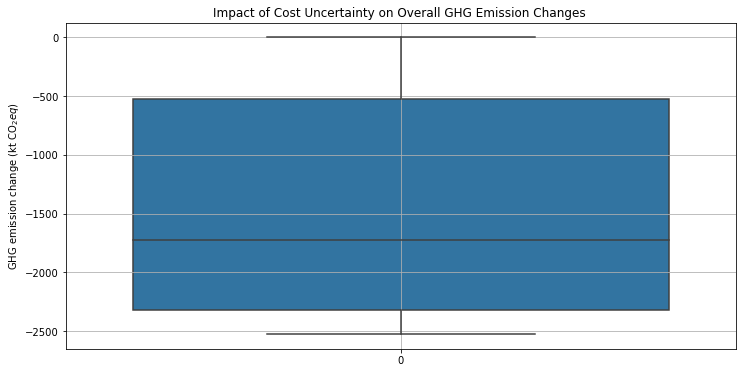

In [22]:
# Plot boxplots for mix_1 and mix_2 columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_unit_obj['obj_value'])
plt.title('Impact of Cost Uncertainty on Overall GHG Emission Changes ')
plt.ylabel('GHG emission change (kt CO$_2eq$)')
plt.grid(True)

plt.savefig(folder_GHG / f'Overall GHG Emission Changes_{num_samples}.png')
plt.show()

## 8 结果处理

In [23]:
# 处理完文件导出位置
output_path = os.path.join(folder_GHG, "num_processed")
os.makedirs(output_path, exist_ok=True)

In [24]:
origin_wipp = ['opt_weight_wipp' 
               ,'Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport'
               ,'Total_emission_change'
               ,'Transportation cost','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']



to_update_wipp = ['opt_weight_wipp'
               ,'GHGE_W1','GHGE_W2','GHGE_W3','GHGE_W4'
               ,'GHGE_Wtotal'
               ,'E_W1','E_W2','E_W3'
               ,'E_Wtotal']

column_map_wipp = dict(zip(to_update_wipp, origin_wipp))

province_order = ['Heilongjiang','Inner Mongolia','Jilin','Liaoning', # East Grid
                  'Gansu','Ningxia','Qinghai','Shaanxi','Xinjiang', # Northwest Grid
                  'Beijing','Hebei','Shandong','Shanxi','Tianjin', # North Grid
                  'Chongqing','Henan','Hubei','Hunan','Jiangxi','Sichuan',# Central Grid
                  'Anhui','Fujian','Jiangsu','Shanghai','Zhejiang', # Northeast Grid
                  'Guangdong','Guangxi','Guizhou','Hainan','Yunnan'] # South Grid

In [25]:
# to_dict - map
df_plant_wwtp = pd.read_excel(r"E:\Test\Inputs\wastewater_treatment_plants_5218.xlsx")
i_province = df_plant_wwtp.set_index('FID')['Pro_en'].to_dict()

k_province = df_plant_waste.set_index('FID')['Pro_en'].to_dict()
k_cl = df_plant_waste.set_index('FID')['Capacity_elec_MW'].to_dict()

In [26]:
I_total_by_num = []


for num in range(100):

    file_wipp = os.path.join(folder_GHG,fr"wipp_{num}.csv")
    df_wipp = pd.read_csv(file_wipp)
    
    sum_wipp = df_wipp.groupby('I')['opt_weight_wipp'].sum().reset_index()
    sum_wipp['num'] = num
    I_total_by_num.append(sum_wipp)
    


    # Convert to MultiIndex DataFrame for easy lookup
    df_wipp.set_index(['I', 'K', 'M'], inplace=True)
    
    for col in origin_wipp[1:]:
        df_wipp[col] = 0
    df_wipp['distance'] = 0
    
    df_wipp['Fuel combustion'] = df_wipp['opt_weight_wipp']* GHG_SludgeBurn 
    opt_weight_wipp = df_wipp['opt_weight_wipp']
    for i, k, m in df_wipp.index:
        opt_weight = opt_weight_wipp.loc[(i, k, m)]
        df_wipp.loc[(i, k, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_wipp.loc[(i, k, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_waste[k] 
        df_wipp.loc[(i, k, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_WIPP[i, k]
        
        df_wipp.loc[(i, k, m),'Transportation cost'] = opt_weight * Distance_WIPP[i,k]*0.65 
        df_wipp.loc[(i, k, m),'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m] 
        df_wipp.loc[(i, k, m),'Co-combustion cost'] = opt_weight * NC_cowaste[num] 
        
        df_wipp.loc[(i, k, m),'distance'] = Distance_WIPP[i,k] 
    
    df_wipp['Total_emission_change'] = df_wipp[['Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport']].sum(axis=1)  
    df_wipp['Economic_total'] = df_wipp[['Transportation cost','Sludge treatment fee','Co-combustion cost']].sum(axis=1)  


        
    df_wipp.reset_index(inplace=True)
    df_wipp['i_pro'] = df_wipp['I'].map(i_province)
    df_wipp['k_pro'] = df_wipp['K'].map(k_province)
    df_wipp['cap_level'] = df_wipp['K'].map(k_cl)
    
    wipp_processed = os.path.join(output_path, fr"wipp_{num}.csv")
    df_wipp.to_csv(wipp_processed, index=False)    
    
                        
I_total = pd.concat(I_total_by_num, ignore_index=True)
I_total.to_csv(os.path.join(output_path,'I_total_by_num.csv'),index=False)